In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#!wget --no-check-certificate \
#    https://raw.githubusercontent.com/KeithGalli/sklearn/master/data/sentiment/Books_small_10000.json \
#    -O /tmp/reviews.json
#!wget --no-check-certificate \
#    http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books_5.json.gz \
#    -O '/content/drive/My Drive/Colab Notebooks/reviews.json.gz'

--2020-05-03 11:24:53--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7096438325 (6.6G) [application/octet-stream]
Saving to: ‘/content/drive/My Drive/Colab Notebooks/reviews.json.gz’

/content/drive/My D 100%[===================>]   6.61G  10.9MB/s    in 12m 33s 

2020-05-03 11:37:26 (8.99 MB/s) - ‘/content/drive/My Drive/Colab Notebooks/reviews.json.gz’ saved [7096438325/7096438325]



In [0]:
!gunzip -c '/content/drive/My Drive/Colab Notebooks/reviews.json.gz' > /tmp/reviews.json

In [3]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.2.0-rc3


In [7]:
reviews_num = 300000
embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .9


with open("/tmp/reviews.json", 'r') as f:
  sentences = []
  labels = []
  neg = 0
  pos = 0
  for line in f:
    item = json.loads(line)
    valid = ('reviewText' in item) and ('overall' in item)
    if valid:
      sentence = item['reviewText']
      # Remove punctuation
      sentence = sentence.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
      sentence = sentence.lower()
      sentences.append(sentence)
      is_positive = item['overall'] > 2.5
      if is_positive:
        pos += 1
      else:
        neg += 1
      labels.append(int(is_positive))
    if len(sentences) == reviews_num:
      break

print(len(sentences))
print(neg)
print(pos)

training_size = int(training_portion * len(sentences))
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;



300000
23436
276564
154172
--2020-05-03 13:05:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  52.2MB/s    in 6.7s    

2020-05-03 13:05:13 (49.4 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [9]:
tot = neg + pos
weight_for_0 = tot/neg/2.0 
weight_for_1 = tot/pos/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 6.40
Weight for class 1: 0.54


In [10]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          15417300  
_________________________________________________________________
dropout (Dropout)            (None, 120, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 15,453,461
Trainable params: 36,161
Non-trainable params: 15,417,300
_________________________________________________________________


In [11]:
num_epochs = 10
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(
  training_padded,
  training_labels,
  epochs=num_epochs,
  validation_data=(testing_padded, testing_labels),
  class_weight = class_weight,
  verbose=1)


Epoch 1/10
8438/8438 [==============================] - 125s 15ms/step - loss: 0.4819 - accuracy: 0.7403 - val_loss: 0.3007 - val_accuracy: 0.8678
Epoch 2/10
8438/8438 [==============================] - 125s 15ms/step - loss: 0.4172 - accuracy: 0.7938 - val_loss: 0.3433 - val_accuracy: 0.8480
Epoch 3/10
8438/8438 [==============================] - 125s 15ms/step - loss: 0.3943 - accuracy: 0.8071 - val_loss: 0.3172 - val_accuracy: 0.8607
Epoch 4/10
8438/8438 [==============================] - 126s 15ms/step - loss: 0.3798 - accuracy: 0.8146 - val_loss: 0.3210 - val_accuracy: 0.8505
Epoch 5/10
8438/8438 [==============================] - 126s 15ms/step - loss: 0.3695 - accuracy: 0.8216 - val_loss: 0.3143 - val_accuracy: 0.8631
Epoch 6/10
8438/8438 [==============================] - 127s 15ms/step - loss: 0.3648 - accuracy: 0.8239 - val_loss: 0.2572 - val_accuracy: 0.8911
Epoch 7/10
8438/8438 [==============================] - 126s 15ms/step - loss: 0.3584 - accuracy: 0.8289 - val_loss: 0

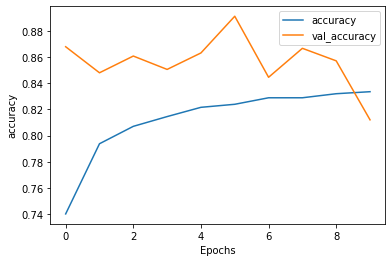

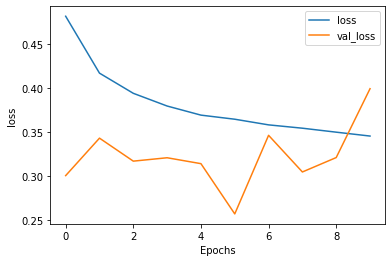

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [13]:
new_reviews = ["This book was very easy to read. I really enjoyed it.", "I would not recommend this book to anyone", "This book is not interesting","I am sure this book is chalk full of good info! However it is certainly not a beginners book to investing. If you're like me and have no idea what the definition of terms like 'net tangible assets', and 'sub working capital' are it may be best to find a true beginners book as a prequel to this one. Lots of good info I cant yet understand."]
new_reviews_stripped = []
for review in new_reviews:
  # Remove punctuation
  review = review.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
  review = review.lower()
  new_reviews_stripped.append(review)
new_reviews_numeric = tokenizer.texts_to_sequences(new_reviews_stripped)
new_reviews_padded = pad_sequences(new_reviews_numeric, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predictions = model.predict(new_reviews_padded);
print(predictions)

[[0.9888954 ]
 [0.06027453]
 [0.02418774]
 [0.13295321]]


In [0]:
with open( 'word_index.json' , 'w' ) as file:    
    json.dump( tokenizer.word_index , file )
model.save("amazon_reviews_sentiment.h5")

In [15]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 1.2MB/s 
     |████████████████████████████████| 104.6MB 56kB/s 
     |████████████████████████████████| 92kB 8.2MB/s 
     |████████████████████████████████| 450kB 26.8MB/s 
     |████████████████████████████████| 3.9MB 37.6MB/s 
     |████████████████████████████████| 256kB 37.4MB/s 
     |████████████████████████████████| 921kB 37.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=3e5a6bf519069495d6f816c221e75fb13133fecf431efeffbd8fc2726aae5417
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=df5b4de49b0ec9a7cdbff9187ed3c0e6f3c6df7a38035464bfc055f72e9c1e07
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built gast PyInquirer
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, bu

In [16]:
import tensorflowjs as tfjs
!tensorflowjs_converter --input_format=keras_saved_model amazon_reviews_sentiment.h5 model/
# tfjs.converters.save_keras_model(model, 'model')
!zip -r /content/model.zip model/

2020-05-03 13:34:05.239329: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-05-03 13:34:05.244176: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2020-05-03 13:34:05.244449: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2e46840 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-03 13:34:05.244484: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-03 13:34:06.594877: W tensorflow/c/c_api.cc:326] Operation '{name:'bidirectional/backward_lstm_1/while' id:497 op device:{} def:{{{node bidirectional/backward_lstm_1/while}} = While[T=[DT_INT32, DT_INT32, DT_INT32, DT_VARIANT, DT_FLOAT, ..., DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT, DT_VARIANT], _l

In [0]:
predictions = model.predict(testing_padded)

0.3319125


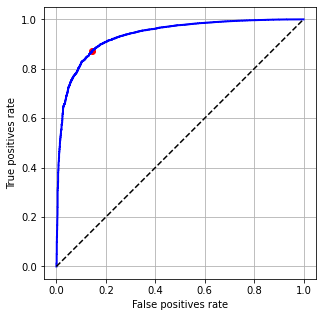

In [18]:
import sklearn.metrics

def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(labels, predictions)
  plt.plot(fpr, tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives rate')
  plt.ylabel('True positives rate')
  plt.grid(True)
  # Youden's J statistic
  J = tpr - fpr
  ix = np.argmax(J)
  best_threshold = thresholds[ix]
  plt.plot([0,1], [0,1], linestyle='--', color='k', label='No Skill')
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='r', label='Best')
  ax = plt.gca()
  ax.set_aspect('equal')
  return best_threshold

plt.figure(figsize=(5,5))
best_threshold = plot_roc(
  "LSTM bidirectional",
  testing_labels,
  predictions,
  color='b')
print(best_threshold)